In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
import pandas as pd #DataFrame을 손쉽게 다루게 해주는 라이브러리
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import graphviz 

# 데이터 경로
#file_path = "/gdrive/MyDrive/colab/dt/PlayTennis.csv"
file_path = "/gdrive/MyDrive/colab/dt/PlayTennis_extraData.csv"
# 데이터 경로로부터 파일을 읽음 (pandas 라이브러리 사용)
datas = pd.read_csv(file_path)

# 데이터 출력 (데이터 형태 확인)
print(datas)

     outlook  temp humidity  windy date      time play
0      sunny   hot     high  False  Thu  13-10-10   no
1      sunny   hot     high   True  Fri  13-45-05   no
2   overcast   hot     high  False  Sat  18-30-15  yes
3      rainy  mild     high  False  Sun  17-15-45  yes
4      rainy  cool   normal  False  Mon  19-00-00  yes
5      rainy  cool   normal   True  Tue  14-25-15   no
6   overcast  cool   normal   True  Wed  16-50-50  yes
7      sunny  mild     high  False  Thu  15-10-00   no
8      sunny  cool   normal  False  Fri  16-10-50  yes
9      rainy  mild   normal  False  Sat  20-55-15  yes
10     sunny  mild   normal   True  Sun  21-30-15  yes
11  overcast  mild     high   True  Mon  17-50-50  yes
12  overcast   hot   normal  False  Tue  16-30-30  yes
13     rainy  mild     high   True  Wed  22-10-05   no


테니스 경기는 야외 경기라는 특성이 있기 때문에 더위로 부터 안전한 16시 이후에 경기가 가능하다.

또한, 주말에는 평일보다 관중 입장이 많아 최대한 경기를 개최한다.

In [3]:
#time 값 hour값을 대표값으로 바꾸기

# Pandas apply 메소드 기반 접근방법 
# 연산속도 엄청빠름

def cleaning(x) :
  if str(x).find("-") != -1 :
    return str(x).split("-")[0]
  return str(x)

def summer(x) :
    if (float(x) >= 16):  #16시 이후는 더위로부터 안전하다.
        return(0)
    else :
        return(1)
    return str(x)

# apply메소드의 lambda 함수는 공백까지 지우기 위해 사용한 코드입니다.

# time에서 hour값 빼고 나머지 지우기
datas['time']=datas['time'].fillna("NONE") #결측값 특정 값으로 채우기
datas['time']=datas['time'].apply(cleaning).apply(lambda x:x.replace(" ",""))
datas['time']=datas['time'].apply(summer)

In [4]:
def cleaning(x) :
  if str(x).find("Sun") != -1 or str(x).find("Sat") != -1 :
      #주말에는 관중이 평일보다 많아 최대한 
    return "weekend"
  else :
      return "weekday"

  return str(x)

# apply메소드의 lambda 함수는 공백까지 지우기 위해 사용한 코드입니다.

# 주말과 평일 나누기
datas['date']=datas['date'].fillna("NONE") #결측값 특정 값으로 채우기
datas['date']=datas['date'].apply(cleaning).apply(lambda x:x.replace(" ",""))

In [5]:
print(datas)

     outlook  temp humidity  windy     date  time play
0      sunny   hot     high  False  weekday     1   no
1      sunny   hot     high   True  weekday     1   no
2   overcast   hot     high  False  weekend     0  yes
3      rainy  mild     high  False  weekend     0  yes
4      rainy  cool   normal  False  weekday     0  yes
5      rainy  cool   normal   True  weekday     1   no
6   overcast  cool   normal   True  weekday     0  yes
7      sunny  mild     high  False  weekday     1   no
8      sunny  cool   normal  False  weekday     0  yes
9      rainy  mild   normal  False  weekend     0  yes
10     sunny  mild   normal   True  weekend     0  yes
11  overcast  mild     high   True  weekday     0  yes
12  overcast   hot   normal  False  weekday     0  yes
13     rainy  mild     high   True  weekday     0   no


In [6]:
#데이터 변환(문자->숫자) 숫자가 더 빠름
# 범주형 데이터를 수치형 데이터로 자동 변환해주는 라이브러리
label_encoder = LabelEncoder()

# 정답 클래스 이름 (yes, no)
target_names = label_encoder.fit(datas['play']).classes_ #.classes_ 내용확인
print("target_names : {}".format(target_names))

datas['outlook'] = label_encoder.fit_transform(datas['outlook'])
datas['temp'] = label_encoder.fit_transform(datas['temp'])
datas['humidity'] = label_encoder.fit_transform(datas['humidity'])
datas['windy'] = label_encoder.fit_transform(datas['windy'])

#주말이냐 아니냐
datas['date'] = label_encoder.fit_transform(datas['date'])

#햇빛이 쨍한 16시 이후 인가 아닌가
datas['time'] = label_encoder.fit_transform(datas['time'])

datas['play'] = label_encoder.fit_transform(datas['play'])

# 데이터 출력 (데이터 포맷 변환 후 결과 확인)
print(datas)

target_names : ['no' 'yes']
    outlook  temp  humidity  windy  date  time  play
0         2     1         0      0     0     1     0
1         2     1         0      1     0     1     0
2         0     1         0      0     1     0     1
3         1     2         0      0     1     0     1
4         1     0         1      0     0     0     1
5         1     0         1      1     0     1     0
6         0     0         1      1     0     0     1
7         2     2         0      0     0     1     0
8         2     0         1      0     0     0     1
9         1     2         1      0     1     0     1
10        2     2         1      1     1     0     1
11        0     2         0      1     0     0     1
12        0     1         1      0     0     0     1
13        1     2         0      1     0     0     0


In [7]:
# 입력 데이터와 정답 데이터로 분리
x_data, y_data = datas.drop(['play'], axis=1), datas['play']

# 분리 결과 확인
print(x_data)
print()
print(y_data)

    outlook  temp  humidity  windy  date  time
0         2     1         0      0     0     1
1         2     1         0      1     0     1
2         0     1         0      0     1     0
3         1     2         0      0     1     0
4         1     0         1      0     0     0
5         1     0         1      1     0     1
6         0     0         1      1     0     0
7         2     2         0      0     0     1
8         2     0         1      0     0     0
9         1     2         1      0     1     0
10        2     2         1      1     1     0
11        0     2         0      1     0     0
12        0     1         1      0     0     0
13        1     2         0      1     0     0

0     0
1     0
2     1
3     1
4     1
5     0
6     1
7     0
8     1
9     1
10    1
11    1
12    1
13    0
Name: play, dtype: int64


In [8]:
# Decision tree 모델 학습 ()
decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy')
train_result = decision_tree.fit(x_data, y_data)

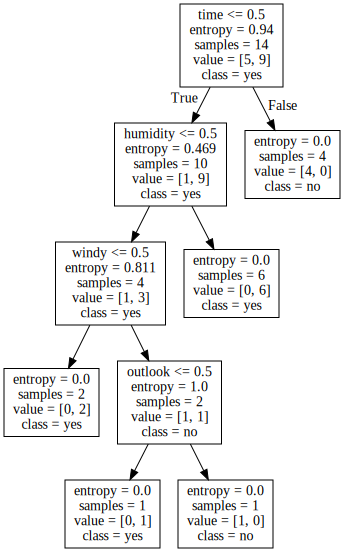

In [9]:
# 학습 결과 확인 (graphviz 라이브러리 사용)
graph = graphviz.Source(tree.export_graphviz(train_result, out_file=None,
                                             feature_names=x_data.columns,
                                             class_names=target_names)) 
graph

In [10]:
# 학습한 모델을 사용하여 예측
predict_result = decision_tree.predict(x_data)

# 예측 결과 출력 (실제 정답을 맞춘 경우 True로 표시됨)
print(predict_result == y_data)

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
Name: play, dtype: bool
